## Importing Library

In [1]:
!pip install pandas_ta
!pip install tabulate

DEPRECATION: Loading egg at c:\program files\python311\lib\site-packages\blinker-1.6.2-py3.11.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package installation..
DEPRECATION: Loading egg at c:\program files\python311\lib\site-packages\click-8.1.7-py3.11.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package installation..
DEPRECATION: Loading egg at c:\program files\python311\lib\site-packages\colorama-0.4.6-py3.11.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package installation..
DEPRECATION: Loading egg at c:\program files\python311\lib\site-packages\contourpy-1.1.0-py3.11-win-amd64.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package installation..
DEPRECATION: Loading egg at c:\program files\python311\lib\site-packages\cycler-0.11.0-py3.11.egg is 

DEPRECATION: Loading egg at c:\program files\python311\lib\site-packages\blinker-1.6.2-py3.11.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package installation..
DEPRECATION: Loading egg at c:\program files\python311\lib\site-packages\click-8.1.7-py3.11.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package installation..
DEPRECATION: Loading egg at c:\program files\python311\lib\site-packages\colorama-0.4.6-py3.11.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package installation..
DEPRECATION: Loading egg at c:\program files\python311\lib\site-packages\contourpy-1.1.0-py3.11-win-amd64.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package installation..
DEPRECATION: Loading egg at c:\program files\python311\lib\site-packages\cycler-0.11.0-py3.11.egg is 

In [2]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import pandas_ta as ta
from tabulate import tabulate
import warnings
warnings.filterwarnings('ignore')

## Declaring Functions

In [3]:
# Bollinger Band Function
def bbands(data,window,std):
    rollmean=data['Close'].rolling(window=window).mean()
    rollstd=data['Close'].rolling(window=window).std()
    upperband=rollmean+std*0.25*rollstd
    lowerband=rollmean-std*0.25*rollstd
    trend=rollmean
    data['UpperBand']=upperband
    data['LowerBand']=lowerband
    data['Trend']=trend
    return data

In [4]:
# Define a function to create and get the Relative  Strength Index (RSI)
def RSI(data,window):
    delta=data['Close'].diff(1) # By-default 1 differencing
    gain=delta.where(delta>0,0)
    loss=delta.where(delta<0,0)
    avg_gain=gain.rolling(window).mean()
    avg_loss=loss.rolling(window).mean()
    RS=avg_gain/avg_loss
    RSI=100-(100/(1+RS))
    data['RSI']=RSI
    data['OverBought']=70
    data['OverSold']=30
    return data


# Applying Strategy

In [5]:
# From Strategy we only creating Buying Signal i.e 2
def strategy(data):
    signal=[]
    for i in range(len(data)):
        if data['Close'][i]<data['LowerBand'][i] and data['RSI'][i]<data['OverSold'][i]:
            indication=2 # Buy Signal
            signal.append('Buy')
        else:
            indication=0 # No signal
            signal.append('Null')
    data['Signal']=signal
    return data


In [6]:
def average_true_range(data, window=14):
    high_low = data['High'] - data['Low']
    high_close = (data['High'] - data['Close']).abs()
    low_close = (data['Low'] - data['Close']).abs()
    ranges = pd.concat([high_low, high_close, low_close], axis=1)
    true_range = ranges.max(axis=1)
    data['ATR'] = true_range.rolling(window=window).mean()
    return data

# Marking Take Profit line and Stop Loss line

In [7]:
# take profit stop loss function for ATR function
def tpsl(data):
    data['Take Profit']=0
    data['Stop Loss']=0
    for i in range(len(data)):
        if data['Signal'][i] == 'Buy':
            data['Take Profit'][i] = 15.0 * data['ATR'][i]
            data['Stop Loss'][i] = 12.0* data['ATR'][i]
        else:
            data['Take Profit'][i] = np.nan
            data['Stop Loss'][i] = np.nan

    return data



In [8]:
def target(data):
    target = []

    for i in range(len(data)):
        if data.Signal[i] == 'Buy':
            buy_price = data.Close[i]
            hit_target = False  # This flag will indicate if TP or SL was hit

            for j in range(i + 1, len(data)):  # Starting from i+1 because we want to check the candles after the buy signal
                if buy_price + data['Take Profit'][i] <= data['Close'][j]:
                    target.append(buy_price + data['Take Profit'][i])
                    hit_target = True
                    break
                elif buy_price - data['Stop Loss'][i] >= data['Close'][j]:
                    target.append(buy_price - data['Stop Loss'][i])
                    hit_target = True
                    break

            # If we reached the end of the dataset without hitting TP or SL
            if not hit_target:
                target.append(np.nan)
        else:
            target.append(np.nan)

    data['Target']=target
    return data


## Calling Function

In [9]:
def best_param_bris(df):
    best_pnl = float('-inf')
    best_moving_avg = None
    best_rsi_moving_avg = None
    best_std = None

    for i in range(15, 30):
        for j in range(2, 15):
            for k in range(10, 25):
                data = df.copy()  # Create a copy of the original data
                data = bbands(data, i, j)
                data = RSI(data, k)
                data = average_true_range(data)
                data.dropna(inplace=True)
                data = strategy(data)
                data = tpsl(data)
                data = target(data)

                df_buy = data[data['Signal'] == 'Buy']  # Filter data for 'Buy' signals
                if not df_buy.empty:
                    df_buy['PNL'] = data['Target'] - data['Close']
                    pnl = df_buy['PNL'].sum()
                    # if pnl > best_pnl:
                    best_pnl = pnl
                    best_moving_avg = i
                    best_std = j
                    best_rsi_moving_avg = k

                    best_params = {
                        'Best PNL': best_pnl,
                        'Best Moving Average BBand': best_moving_avg,
                        'Best Moving Average RSI': best_rsi_moving_avg,
                        'Best STD BBand': best_std
                    }

                    print(best_params)
    # return best_params


In [ ]:
best_param_bris(data)

{'Best PNL': -2551.6044205461253, 'Best Moving Average BBand': 15, 'Best Moving Average RSI': 10, 'Best STD BBand': 2}
{'Best PNL': -2224.626257331032, 'Best Moving Average BBand': 15, 'Best Moving Average RSI': 11, 'Best STD BBand': 2}
{'Best PNL': -2514.4755910805316, 'Best Moving Average BBand': 15, 'Best Moving Average RSI': 12, 'Best STD BBand': 2}
{'Best PNL': -2361.943299273081, 'Best Moving Average BBand': 15, 'Best Moving Average RSI': 13, 'Best STD BBand': 2}
{'Best PNL': -2737.769943543842, 'Best Moving Average BBand': 15, 'Best Moving Average RSI': 14, 'Best STD BBand': 2}
{'Best PNL': -2389.7710704599112, 'Best Moving Average BBand': 15, 'Best Moving Average RSI': 15, 'Best STD BBand': 2}
{'Best PNL': -2568.545708417894, 'Best Moving Average BBand': 15, 'Best Moving Average RSI': 16, 'Best STD BBand': 2}
{'Best PNL': -2634.0894341060102, 'Best Moving Average BBand': 15, 'Best Moving Average RSI': 17, 'Best STD BBand': 2}
{'Best PNL': -2838.0467042037426, 'Best Moving Avera

KeyboardInterrupt: ignored

## DATASET

In [10]:
data=yf.download('MSFT',period='10y',interval='1d')


[*********************100%%**********************]  1 of 1 completed


In [11]:
data=bbands(data,15,7)
data=RSI(data,21)
data=average_true_range(data)
data.dropna(inplace=True)
data=strategy(data)

In [12]:
data.Signal.value_counts()

Signal
Null    2387
Buy      110
Name: count, dtype: int64

In [13]:
data=tpsl(data)
data

,Open,High,Low,Close,Adj Close,Volume,UpperBand,LowerBand,Trend,RSI,OverBought,OverSold,ATR,Signal,Take Profit,Stop Loss
Date,,,,,,,,,,,,,,,,
2014-07-18,44.650002,44.840000,44.250000,44.689999,38.110680,43407500,44.297332,40.586667,42.442000,147.798872,70,30,0.665715,Null,NaN,NaN
2014-07-21,44.560001,45.160000,44.220001,44.840000,38.238586,37604400,44.758091,40.471242,42.614666,145.645749,70,30,0.696429,Null,NaN,NaN
2014-07-22,45.000000,45.150002,44.590000,44.830002,38.230076,43095800,45.134599,40.512067,42.823333,148.571487,70,30,0.703572,Null,NaN,NaN
2014-07-23,45.450001,45.450001,44.619999,44.869999,38.264179,52362900,45.458123,40.588544,43.023333,153.125141,70,30,0.736429,Null,NaN,NaN
2014-07-24,44.930000,45.000000,44.320000,44.400002,37.863388,30725300,45.634503,40.745497,43.190000,166.414993,70,30,0.754286,Null,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-12,435.320007,443.399994,433.250000,441.059998,441.059998,22366200,438.990405,411.749597,425.370001,188.953841,70,30,7.040710,Null,NaN,NaN
2024-06-13,440.850006,443.390015,439.369995,441.579987,441.579987,15960600,441.450388,410.764281,426.107334,197.202188,70,30,6.743570,Null,NaN,NaN
2024-06-14,438.279999,443.140015,436.720001,442.570007,442.570007,13582000,444.203622,410.087048,427.145335,224.781688,70,30,6.727142,Null,NaN,NaN


In [14]:
data=target(data)

In [15]:
buy=[]
for i in range(len(data)):
    if data.Signal[i]=='Buy':
        buy.append(data.Close[i])
    else:
        buy.append(np.nan)

df=data.copy()
df['Buy']=buy

## Plotting Graph of Buy SIGNAL

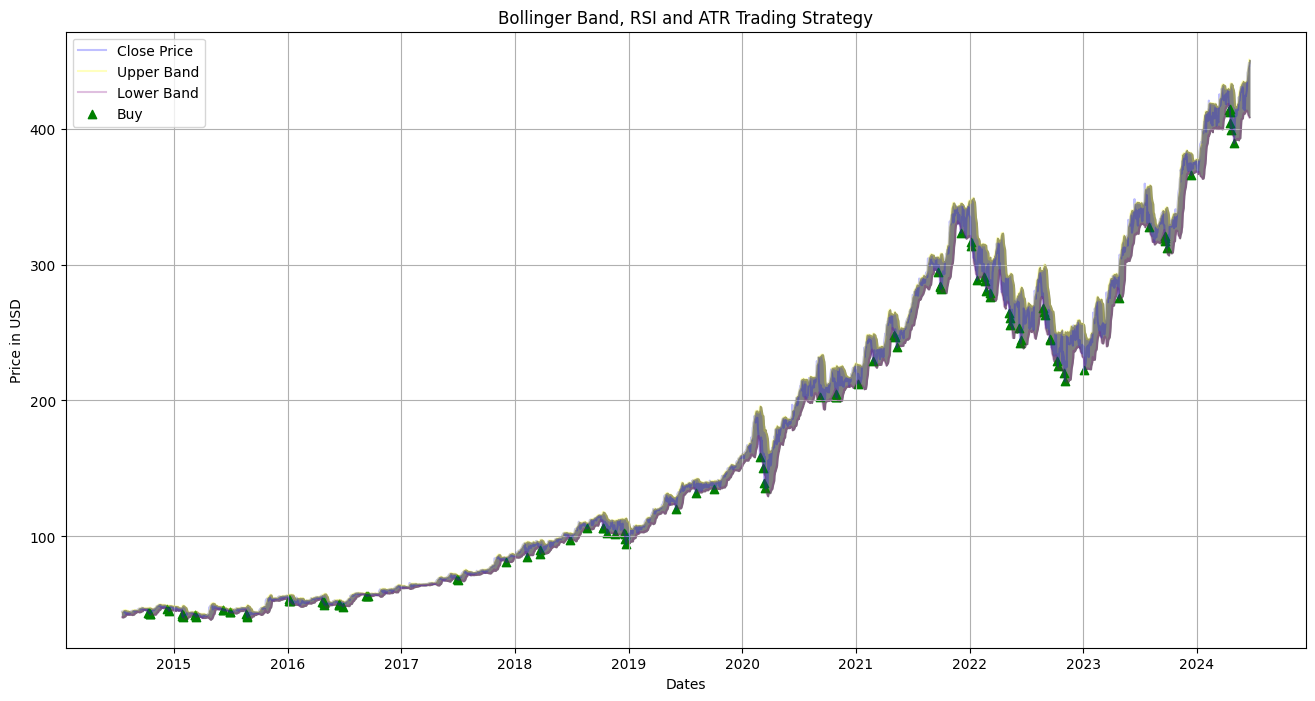

In [16]:
# Plot the close price , bollinger bands and trading signals(buy & sell signals)
fig,ax=plt.subplots(figsize=(16,8))
plt.title('Bollinger Band, RSI and ATR Trading Strategy')
plt.grid(True)
plt.ylabel('Price in USD')
plt.xlabel('Dates')
ax.plot(data['Close'],label='Close Price',alpha=0.25,color='blue')
ax.plot(data['UpperBand'],label='Upper Band',alpha=0.25,color='yellow')
ax.plot(data['LowerBand'],label='Lower Band',alpha=0.25,color='purple')
ax.fill_between(data.index,data['UpperBand'],data['LowerBand'],color='grey')
ax.scatter(df.index,df['Buy'],label='Buy',alpha=1,marker='^',color='green')
plt.legend()
plt.show()

## This is a dataframe in which only buy with their take profit and stop loss
......

In [17]:
df

,Open,High,Low,Close,Adj Close,Volume,UpperBand,LowerBand,Trend,RSI,OverBought,OverSold,ATR,Signal,Take Profit,Stop Loss,Target,Buy
Date,,,,,,,,,,,,,,,,,,
2014-07-18,44.650002,44.840000,44.250000,44.689999,38.110680,43407500,44.297332,40.586667,42.442000,147.798872,70,30,0.665715,Null,NaN,NaN,NaN,NaN
2014-07-21,44.560001,45.160000,44.220001,44.840000,38.238586,37604400,44.758091,40.471242,42.614666,145.645749,70,30,0.696429,Null,NaN,NaN,NaN,NaN
2014-07-22,45.000000,45.150002,44.590000,44.830002,38.230076,43095800,45.134599,40.512067,42.823333,148.571487,70,30,0.703572,Null,NaN,NaN,NaN,NaN
2014-07-23,45.450001,45.450001,44.619999,44.869999,38.264179,52362900,45.458123,40.588544,43.023333,153.125141,70,30,0.736429,Null,NaN,NaN,NaN,NaN
2014-07-24,44.930000,45.000000,44.320000,44.400002,37.863388,30725300,45.634503,40.745497,43.190000,166.414993,70,30,0.754286,Null,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-12,435.320007,443.399994,433.250000,441.059998,441.059998,22366200,438.990405,411.749597,425.370001,188.953841,70,30,7.040710,Null,NaN,NaN,NaN,NaN
2024-06-13,440.850006,443.390015,439.369995,441.579987,441.579987,15960600,441.450388,410.764281,426.107334,197.202188,70,30,6.743570,Null,NaN,NaN,NaN,NaN
2024-06-14,438.279999,443.140015,436.720001,442.570007,442.570007,13582000,444.203622,410.087048,427.145335,224.781688,70,30,6.727142,Null,NaN,NaN,NaN,NaN


In [18]:
df['PNL']=data['Target']-data['Close']

In [19]:
df['PNL'].sum()

4605.325285230364

In [20]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'UpperBand',
       'LowerBand', 'Trend', 'RSI', 'OverBought', 'OverSold', 'ATR', 'Signal',
       'Take Profit', 'Stop Loss', 'Target', 'Buy', 'PNL'],
      dtype='object')

## Doing Backtesting Now,

In [21]:
df2=data.copy()

In [28]:
import pandas as pd
from tabulate import tabulate

class Backtest:
    def __init__(self):
        self.columns = ['Equity Name', 'Trade', 'Entry Time', 'Entry Price', 'Exit Time', 'Exit Price', 'Quantity', 'Position Size', 'PNL', '% PNL']
        self.backtesting = pd.DataFrame(columns=self.columns)
        self.stop_loss = None
        self.take_profit = None

    def set_stop_loss(self, price):
        self.stop_loss = price

    def remove_stop_loss(self):
        self.stop_loss = None

    def set_take_profit(self, price):
        self.take_profit = price

    def remove_take_profit(self):
        self.take_profit = None

    def buy(self, equity_name, entry_time, entry_price, qty):
        self.trade_board = dict(zip(self.columns, [None] * len(self.columns)))
        self.trade_board['Trade'] = 'Open'
        self.trade_board['Quantity'] = qty
        self.trade_board['Position Size'] = round(self.trade_board['Quantity'] * entry_price, 3)
        self.trade_board['Equity Name'] = equity_name
        self.trade_board['Entry Time'] = entry_time
        self.trade_board['Entry Price'] = round(entry_price, 2)

    def sell(self, exit_time, exit_price, exit_type, charge=0):
        exit_timestamp = data.index[exit_time]
        self.trade_board['Holding Days'] = (exit_timestamp - self.trade_board['Entry Time']).days
        self.trade_board['Exit Time'] = exit_time
        self.trade_board['Exit Price'] = round(exit_price, 2)
        self.trade_board['Trade'] = 'Closed'
        self.trade_board['Exit Type'] = exit_type
        self.trade_board['PNL'] = round((self.trade_board['Exit Price'] - self.trade_board['Entry Price']) * self.trade_board['Quantity'], 2)
        self.trade_board['% PNL'] = round((self.trade_board['PNL'] / self.trade_board['Position Size']) * 100, 3)
        new_row = pd.DataFrame([self.trade_board])
        self.backtesting = pd.concat([self.backtesting, new_row], ignore_index=True)

    def stats(self):
        df = self.backtesting
        df2 = df.copy()
        parameters = ['Total Trade Scripts', 'Total Trade', 'PNL', 'Winners', 'Losers', 'Win Ratio', 'Total Profit', 'Total Loss', 'Max Loss Trade', 'Max Profitable Trade', 'Average Loss per Trade', 'Average Profit per Trade', 'Average PNL Per Trade', 'Risk Reward']
        total_traded_scripts = len(df['Equity Name'].unique())
        total_trade = len(df.index)
        pnl = df.PNL.sum()
        winners = len(df[df.PNL > 0])
        losers = len(df[df.PNL <= 0])
        win_ratio = str(round((winners / total_trade) * 100, 2)) + '%'
        total_profit = round(df[df.PNL > 0].PNL.sum(), 2)
        total_loss = round(df[df.PNL <= 0].PNL.sum(), 2)
        max_loss_trade = round(df[df.PNL <= 0].PNL.min(), 3)
        max_profit_trade = round(df[df.PNL >= 0].PNL.max(), 3)
        average_loss_per_trade = round(total_loss / losers, 2)
        average_profit_per_trade = round(total_profit / winners, 2)
        average_pnl_per_trade = round(pnl / total_trade, 2)
        risk_reward = f'1:{-1 * round(average_profit_per_trade / average_loss_per_trade, 2)}'
        data_points = [total_traded_scripts, total_trade, pnl, winners, losers, win_ratio, total_profit, total_loss, max_loss_trade, max_profit_trade, average_loss_per_trade, average_profit_per_trade, average_pnl_per_trade, risk_reward]
        data = list(zip(parameters, data_points))
        x = tabulate(data, ['Parameters', 'Values'], tablefmt='psql')
        return x


In [31]:
def backtest_strategy(data):
    bt = Backtest()
    capital=100000
    for i in range(len(data)):
        if data.Signal[i] == 'Buy':
            qty = capital // data.Open[i]
            bt.buy(equity_name='MSFT',entry_time=data.index[i], entry_price=data.Close[i],qty=qty)
            bt.set_take_profit(data.Close[i] + data['Take Profit'][i])
            bt.set_stop_loss(data.Close[i] - data['Stop Loss'][i])
            for j in range(i + 1, len(data)):
                if data.Close[j] >= bt.take_profit:
                    bt.sell(exit_time=j, exit_price=bt.take_profit,exit_type='Take Profit')
                    break
                elif data.Close[j] <= bt.stop_loss:
                    bt.sell(exit_time=j, exit_price=bt.stop_loss, exit_type='Stop Loss')
                    break

            if bt.trade_board['Trade'] == 'Open':  # If still open by end of data
                bt.sell(exit_time=len(data)-1, exit_price=data.Close.iloc[-1], exit_type='End of Data')

    return bt.backtesting,bt.stats()

In [32]:
data1,x=backtest_strategy(data)

In [33]:
data1

,Equity Name,Trade,Entry Time,Entry Price,Exit Time,Exit Price,Quantity,Position Size,PNL,% PNL,Holding Days,Exit Type
0,MSFT,Closed,2014-10-10,44.03,515,56.86,2192.0,96513.757,28123.36,29.139,663.0,Take Profit
1,MSFT,Closed,2014-10-13,43.65,516,57.08,2282.0,99609.303,30647.26,30.767,661.0,Take Profit
2,MSFT,Closed,2014-10-14,43.73,516,57.21,2279.0,99660.669,30720.92,30.826,660.0,Take Profit
3,MSFT,Closed,2014-10-15,43.22,515,56.95,2325.0,100486.503,31922.25,31.768,658.0,Take Profit
4,MSFT,Closed,2014-10-16,42.74,365,56.47,2351.0,100481.744,32279.23,32.124,439.0,Take Profit
...,...,...,...,...,...,...,...,...,...,...,...,...
105,MSFT,Closed,2024-04-16,414.58,2496,446.34,241.0,99913.777,7654.16,7.661,63.0,End of Data
106,MSFT,Closed,2024-04-17,411.84,2496,446.34,239.0,98429.759,8245.50,8.377,62.0,End of Data
107,MSFT,Closed,2024-04-18,404.27,2496,446.34,243.0,98237.607,10223.01,10.406,61.0,End of Data
108,MSFT,Closed,2024-04-19,399.12,2496,446.34,247.0,98582.639,11663.34,11.831,60.0,End of Data


In [35]:
data1.to_csv('Summary_of_trade_MSFT.csv')

In [36]:
def calculate_equity_curve(data):
    equity_curve = [0]  # Initialize with zero equity
    for i in range(1, len(data)):
        equity_curve.append(equity_curve[-1] + data['PNL'][i])  # Calculate equity for each day

    return equity_curve

# Assuming you have a DataFrame named 'data1' with 'PNL' values
equity_curve = calculate_equity_curve(data1)




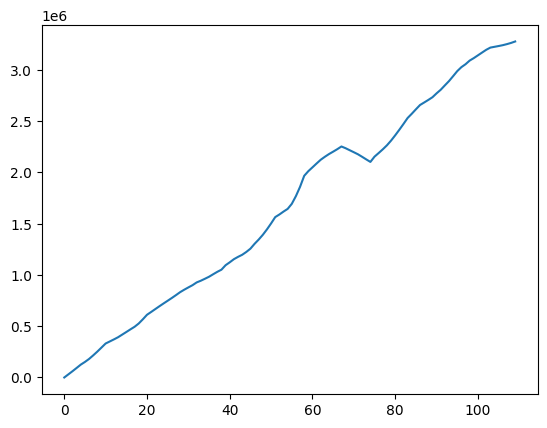

In [37]:
plt.plot(equity_curve)

In [38]:
print(x)

+--------------------------+------------+
| Parameters               | Values     |
|--------------------------+------------|
| Total Trade Scripts      | 1          |
| Total Trade              | 110        |
| PNL                      | 3303263.23 |
| Winners                  | 103        |
| Losers                   | 7          |
| Win Ratio                | 93.64%     |
| Total Profit             | 3453696.87 |
| Total Loss               | -150433.64 |
| Max Loss Trade           | -25300.08  |
| Max Profitable Trade     | 106871.52  |
| Average Loss per Trade   | -21490.52  |
| Average Profit per Trade | 33531.04   |
| Average PNL Per Trade    | 30029.67   |
| Risk Reward              | 1:1.56     |
+--------------------------+------------+


In [39]:
max_drawdown = 0  # Initialize the maximum drawdown to 0
peak = equity_curve[0]  # Initialize the peak value

for i in range(1, len(equity_curve)):
    if equity_curve[i] > peak:
        peak = equity_curve[i]  # Update the peak value if a new high is reached
    else:
        drawdown = (equity_curve[i] - peak) / peak  # Calculate the drawdown
        if drawdown < max_drawdown:
            max_drawdown = drawdown  # Update the maximum drawdown if a greater drawdown is encountered
print(max_drawdown*-100,'%')

# The variable 'max_drawdown' now contains the maximum drawdown as a decimal value


6.6813591423717735 %


In [40]:
maximum_drawdown=17.75

In [41]:
data1['PNL'].sum()

3303263.23

In [42]:
equity_starting=100000
total_returns = (data1['PNL'].sum() - equity_starting) / equity_starting
total_returns_percentage = total_returns * 100

sharpe_ratio = total_returns / maximum_drawdown



In [43]:
print(sharpe_ratio)


1.8046553408450705
